### Dimensionality Reduction for IBL Neuropixel Data

This notebook is intended to demonstrate the dimensionality reduction code and analysis approaches for IBL neural data. The code is prototype level code from the IBL Code Camp hackathon. In this notebook you will need to set and load data and then you can use the dimensionality reduction functions provided in the dim_reduce.py module. This module needs to be on your python path or in the kernel's execution directory.

#CRITICAL ADDITIONS: 

1. •••••cross validate the methods••••••••
2. Grid search -- run through all possible variables 
3. Optimize and add parameters for each method
4. Add ability to choose colormap (currently hard coded into the plotting function). Note wheel position should be a cyclic colorpam, e.g. hsv
5. Latenet variables from the GLM group to add to the current list of possible variables
6. Add methods: dPCA (Eric has code), VAE (Leenoy has code), GPFA (Leenoy hs code), TDA (ripser for topological balls /KeplerMapper for simplicial complexes)
7. setup file that adds the UMAP and tda packages, and maybe tensorflow as well
8. Flag when there arent enough observations for number of neurons
9. Make LDA work it surrently fails...

In [44]:
# we will append any local directories needed for packages and
# development modules not installed in the conda 'ibllib' environment

# core python
import sys
from pathlib import Path


# sys.path.append(r'C:\Leenoy\Postdoc 1st year\IBL\Code_camp_September_2019\data_code_camp\dim_red_WG\umap-master')
# sys.path.append('/Users/dep/Workspaces/Rodent/IBL/ibllib')
sys.path.append('/Users/alex/Documents/PYTHON/ibl-dimensionality_reduction')
sys.path.append('/Users/alex/Documents/PYTHON/ibllib')



# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import umap
import umap

from sklearn.datasets import fetch_openml

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# ibl
import alf.io  
from brainbox.processing import bincount2D
import ibllib.plots as iblplt
import dim_reduce

# data location and loading
Note that we will be converting the data structrures used in the following weeks,
so this code currently uses base alf objects and a dictionaries, but it will be converted
to use Bunch and also Panda Dataframes

In [4]:
# define the path to the sessions we downloaded 
# main_path = Path(r'C:\Leenoy\Postdoc 1st year\IBL\Code_camp_September_2019\data_code_camp')
main_path = Path('/Users/alex/Downloads/')
SES = {
    'A': main_path.joinpath(Path('ZM_1735/2019-08-01/001')), # RSC --> CA1 --> midbrain, good behavior, bad recroding
    'B': main_path.joinpath(Path('ibl_witten_04_002/2019-08-04/002')), # visual cortex, good behavior, noisy recording
    'C': main_path.joinpath(Path('ZM_1736/2019-08-09/004')),  # left probe, bad behavior, good recording
    'D': main_path.joinpath(Path('ibl_witten_04_001/2018-08-11/001')), # motor cortex, bad beahvior, good recording
    'E': main_path.joinpath(Path('KS005/2019-08-29/001')), # activity in in red nucleaus, bad recording (serious lick artifacts and some units saturated) 
#    'F': main_path.joinpath(Path('KS005/2019-08-30/001')), # too large, didnt download for now
}

# select a session from the bunch
sid = 'A'
ses_path = Path(SES[sid])

# read in the alf objects
alf_path = ses_path / 'alf'
spikes = alf.io.load_object(alf_path, 'spikes')  #can be addressed as spikes['time'] or spikes.time
clusters = alf.io.load_object(alf_path, 'clusters')
channels = alf.io.load_object(alf_path, 'channels')
trials = alf.io.load_object(alf_path, '_ibl_trials')
wheel = alf.io.load_object(alf_path, '_ibl_wheel')

2019-09-06 16:50:20.5 WARNING  [io.py:144] Inconsistent dimensions for object:clusters[('mlapdv', (712, 3)), ('amps', (712,)), ('peakChannel', (712,)), ('brainAcronyms', (712, 1)), ('waveformDuration', (712, 712)), ('probes', (712,)), ('depths', (712,)), ('templateWaveforms', (712, 82, 748))]


# functions from dim_reduce


# Parameters for analysis
T_BIN is the size in seconds of the bins applied to the neural data

In [20]:
T_BIN = 0.1
TRIALS_TO_PLOT = np.arange(1,10) # note that we use the real trial numbers
PROJECTED_DIMENSIONS = 3
BEHAVIORAL_VARIABLE = 'choice'


# Prepare the data

In [21]:
binned_data = dim_reduce.bin_types(spikes, trials, wheel, T_BIN, clusters, brain_area = 'MOs5' )

Range of trials:  [1, 390]


In [22]:
neural_data, variable_data = dim_reduce.get_trials(binned_data, BEHAVIORAL_VARIABLE, TRIALS_TO_PLOT)

# Principle Component Analysis
The following code cell runs PCA using the wheel velocity for color

Text(0.5, 0.92, "PCA Guido's secondary motor vs choice")

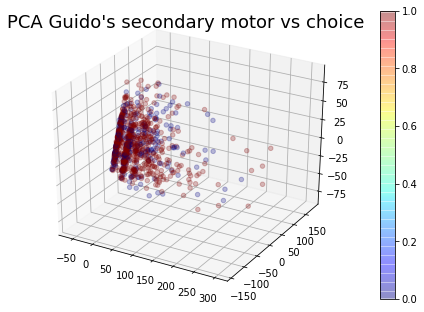

In [25]:
SVD_SOLVER='full'

pca_projected_data = PCA(n_components=PROJECTED_DIMENSIONS, svd_solver= SVD_SOLVER).fit_transform(neural_data)
ax = dim_reduce.color_3D_projection(pca_projected_data, variable_data)
ax.set_title("PCA Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Demixed Principle Components Analysis
The following code cell runs demixed PCA

In [59]:
# TODO: copy in dPCA

# Factor Analysis

Text(0.5, 0.8464, "Factor Analysis Guido's secondary motor vs choice")

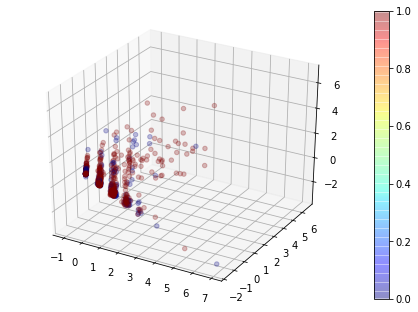

In [26]:
fa_projected_data = FactorAnalysis(n_components=PROJECTED_DIMENSIONS).fit_transform(neural_data)
dim_reduce.color_3D_projection(fa_projected_data, variable_data)
ax.set_title("Factor Analysis Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Independent Component Analysis

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Text(0.5, 0.3996373778857418, "ICA Guido's secondary motor vs choice")

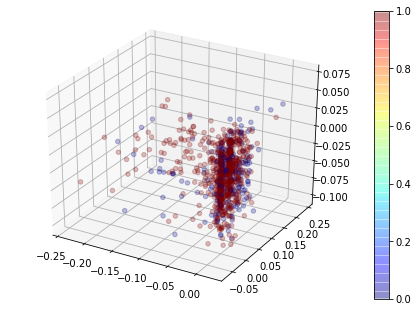

In [45]:
ICA_projected_data = FastICA(n_components=PROJECTED_DIMENSIONS).fit_transform(neural_data)
dim_reduce.color_3D_projection(ICA_projected_data, variable_data)
ax.set_title("ICA Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Isomap

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Text(0.5, 0.778688, "Isomap Guido's secondary motor vs choice")

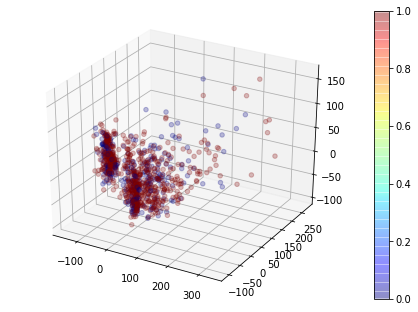

In [27]:
N_NEIGHBORS = 30

Isomap_projected_data = Isomap(n_components=PROJECTED_DIMENSIONS, n_neighbors=N_NEIGHBORS).fit_transform(neural_data)
dim_reduce.color_3D_projection(Isomap_projected_data, variable_data)
ax.set_title("Isomap Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# TSNE

Text(0.5, 0.7163929600000001, "TSNE Guido's secondary motor vs choice")

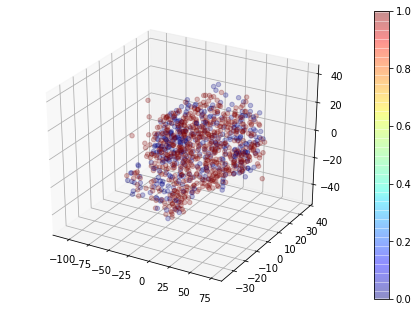

In [28]:
PERPLEXITY=30
# normally ranges 5-50 

TSNE_projected_data = TSNE(n_components=PROJECTED_DIMENSIONS,perplexity=PERPLEXITY).fit_transform(neural_data)
dim_reduce.color_3D_projection(TSNE_projected_data, variable_data)
ax.set_title("TSNE Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Multidimensional Scaling

Text(0.5, 0.6063550013440001, "MDS Guido's secondary motor vs choice")

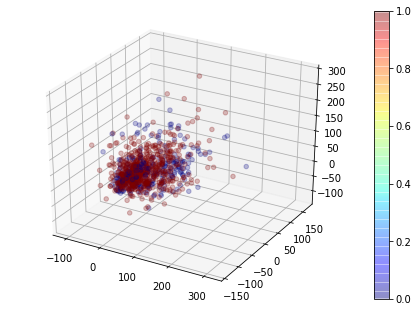

In [30]:
MDS_projected_data = MDS(n_components=PROJECTED_DIMENSIONS).fit_transform(neural_data)
dim_reduce.color_3D_projection(MDS_projected_data, variable_data)
ax.set_title("MDS Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Locally Linear Embedding

Text(0.5, 0.5132188731375618, "LLE Guido's secondary motor vs choice")

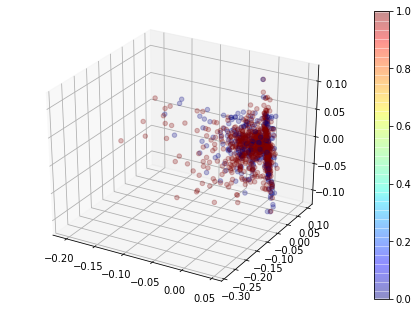

In [33]:
N_NEIGHBORS=30

LLE_projected_data = LocallyLinearEmbedding(n_components=PROJECTED_DIMENSIONS,n_neighbors=N_NEIGHBORS).fit_transform(neural_data)
dim_reduce.color_3D_projection(LLE_projected_data, variable_data)
ax.set_title("LLE Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

# Linear Discriminant Analysis

In [50]:
SOLVER='svd' 

LDA_projected_data = LinearDiscriminantAnalysis(n_components=PROJECTED_DIMENSIONS, solver=SOLVER).fit_transform(neural_data)
dim_reduce.color_3D_projection(LDA_projected_data, variable_data)
ax.set_title("LDA Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)

TypeError: fit() missing 1 required positional argument: 'y'

# UMAP

Text(0.5, 0.4343884542236323, "UMAP Guido's secondary motor vs choice")

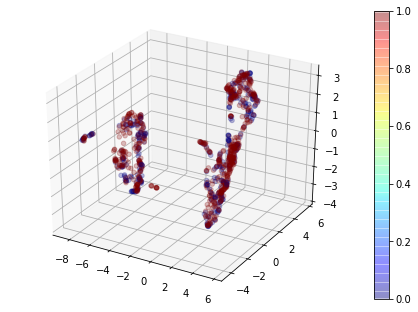

In [39]:
MIN_DISTANCE=0.3
N_NEIGHBORS=5

UMAP_projected_data = umap.UMAP(n_components=PROJECTED_DIMENSIONS,n_neighbors=N_NEIGHBORS).fit_transform(neural_data)
dim_reduce.color_3D_projection(UMAP_projected_data, variable_data)
ax.set_title("UMAP Guido's secondary motor vs %s" % BEHAVIORAL_VARIABLE, fontsize=18)